# 2D-CNN pipeline (images ready)

In [61]:
# =============================================
# ====== 1. Imports & Setup ======
# =============================================
import os, random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import iqr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [62]:
# =============================================
# ====== 2. Google Drive Mount & Paths ======
# =============================================
from google.colab import drive
drive.mount('/content/drive/')

# # Unzip if needed
# !unzip /content/CR.zip -d /content/CR

# IMG_DIR = "/content/drive/MyDrive/CR_16_auto_scale"
IMG_DIR = "/content/drive/MyDrive/CR_16_norm"
CSV_PATH = "/content/drive/MyDrive/target_train_488.csv"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
# =============================================
# ====== 3. Configurations ======
# =============================================
TARGETS = ['Moi', 'NDF', 'Starch']
IMG_SIZE = 16
batch_size = 50
epochs = 200
lr = 0.0001
n_splits = 5
seed = 42
plot_name = "RESAMP"

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [64]:
# =============================================
# ====== 4. Data Loading & Scaling ======
# =============================================
df = pd.read_csv(CSV_PATH)
print("Data shape:", df.shape)

# Scale targets
y_scaler = StandardScaler()   # Auto-scale
targets_scaled = y_scaler.fit_transform(df[TARGETS].values.astype(np.float32))

Data shape: (488, 3)


In [65]:
# =============================================
# ====== 5. Dataset Class ======
# =============================================
class SoilImageDataset(Dataset):
    def __init__(self, df, img_dir, targets_scaled, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.targets = targets_scaled.astype(np.float32)
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{plot_name}_{idx}.png")
        img = Image.open(img_path).convert("L").resize((IMG_SIZE, IMG_SIZE))
        img = self.transform(img)
        target = torch.from_numpy(self.targets[idx])
        return img, target

transform = transforms.Compose([transforms.ToTensor()])
dataset = SoilImageDataset(df, IMG_DIR, targets_scaled, transform)
print("Dataset length:", len(dataset))

Dataset length: 488


In [45]:
# # ====== CNN model (as in Table 2) ======
# class CNN2D(nn.Module):
#     def __init__(self, in_channels=1, num_outputs=3): # Changed num_outputs to 3
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2,2)
#         self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
#         self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
#         self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5a = nn.Conv2d(512, 512, 3, padding=1)
#         self.conv5b = nn.Conv2d(512, 512, 3, padding=1)

#         self.flattened = 512 * 2 * 2
#         self.fc1 = nn.Linear(self.flattened, 128)
#         self.fc2 = nn.Linear(128, num_outputs)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.conv1(x)); x = self.pool(x)
#         x = self.relu(self.conv2(x)); x = self.pool(x)
#         x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)
#         x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)
#         x = self.relu(self.conv5a(x)); x = self.relu(self.conv5b(x)); x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         return self.fc2(x)

**16*16 2D CNN**

In [66]:
# =============================================
# ====== 6. CNN Model (16x16 Input) ======
# =============================================
class CNN2D(nn.Module):
    def __init__(self, in_channels=1, num_outputs=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.flattened = 512 * 1 * 1
        self.fc1 = nn.Linear(self.flattened, 128)
        self.fc2 = nn.Linear(128, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x)); x = self.pool(x)  # 16→8
        x = self.relu(self.conv2(x)); x = self.pool(x)  # 8→4
        x = self.relu(self.conv3a(x)); x = self.relu(self.conv3b(x)); x = self.pool(x)  # 4→2
        x = self.relu(self.conv4a(x)); x = self.relu(self.conv4b(x)); x = self.pool(x)  # 2→1
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        return self.fc2(x)


In [67]:
# =============================================
# ====== 7. Metrics Function ======
# =============================================
def compute_metrics_orig(y_true, y_pred):
    results = []
    for i in range(y_true.shape[1]):
        yt, yp = y_true[:, i], y_pred[:, i]
        rmse = np.sqrt(mean_squared_error(yt, yp))
        r2 = r2_score(yt, yp)
        bias = np.mean(yp - yt)
        results.append({"RMSE": rmse, "R2": r2, "Bias": bias})
    return results

In [68]:
# =============================================
# ====== 8. Data Split ======
# =============================================
indices = np.arange(len(dataset))
trainval_idx, test_idx = train_test_split(indices, test_size=0.25, random_state=seed)


========== Fold 1/5 ==========
Epoch 10/200 | Avg Loss: 0.9930
Epoch 20/200 | Avg Loss: 0.8741
Epoch 30/200 | Avg Loss: 0.8883
Epoch 40/200 | Avg Loss: 0.8544
Epoch 50/200 | Avg Loss: 0.8154
Epoch 60/200 | Avg Loss: 0.7975
Epoch 70/200 | Avg Loss: 0.8253
Epoch 80/200 | Avg Loss: 0.7812
Epoch 90/200 | Avg Loss: 0.6630
Epoch 100/200 | Avg Loss: 0.6455
Epoch 110/200 | Avg Loss: 0.6043
Epoch 120/200 | Avg Loss: 0.5914
Epoch 130/200 | Avg Loss: 0.5902
Epoch 140/200 | Avg Loss: 0.5674
Epoch 150/200 | Avg Loss: 0.5764
Epoch 160/200 | Avg Loss: 0.5420
Epoch 170/200 | Avg Loss: 0.5497
Epoch 180/200 | Avg Loss: 0.5882
Epoch 190/200 | Avg Loss: 0.5363
Epoch 200/200 | Avg Loss: 0.5065

Fold Results:
Moi: RMSE=2.973, R2=0.778, Bias=0.378


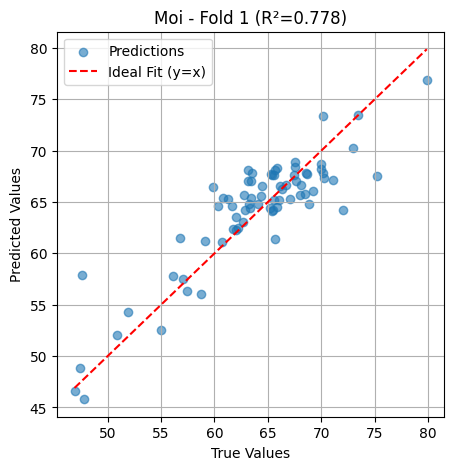

NDF: RMSE=4.715, R2=0.229, Bias=-0.751


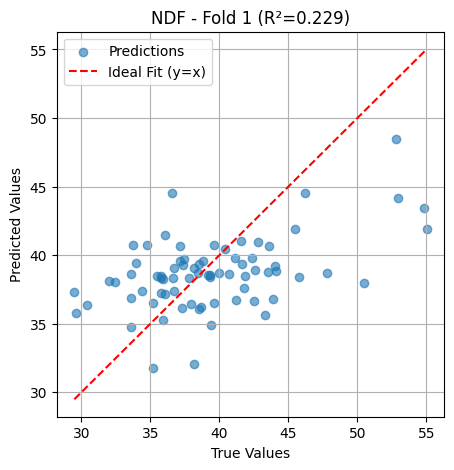

Starch: RMSE=7.325, R2=0.283, Bias=1.442


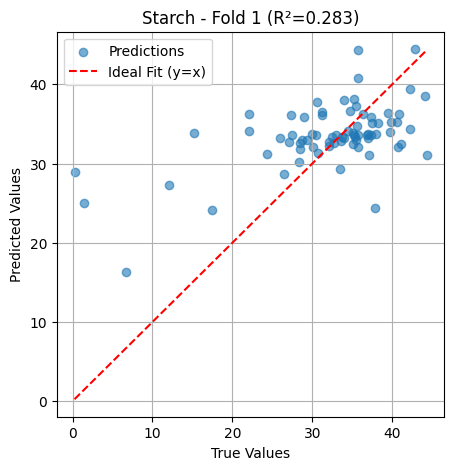


========== Fold 2/5 ==========
Epoch 10/200 | Avg Loss: 0.9816
Epoch 20/200 | Avg Loss: 0.8920
Epoch 30/200 | Avg Loss: 0.8649
Epoch 40/200 | Avg Loss: 0.8589
Epoch 50/200 | Avg Loss: 0.8164
Epoch 60/200 | Avg Loss: 0.7542
Epoch 70/200 | Avg Loss: 0.6562
Epoch 80/200 | Avg Loss: 0.5900
Epoch 90/200 | Avg Loss: 0.5898
Epoch 100/200 | Avg Loss: 0.5424
Epoch 110/200 | Avg Loss: 0.6468
Epoch 120/200 | Avg Loss: 0.5468
Epoch 130/200 | Avg Loss: 0.5830
Epoch 140/200 | Avg Loss: 0.6067
Epoch 150/200 | Avg Loss: 0.5435
Epoch 160/200 | Avg Loss: 0.5123
Epoch 170/200 | Avg Loss: 0.5853
Epoch 180/200 | Avg Loss: 0.5323
Epoch 190/200 | Avg Loss: 0.5139
Epoch 200/200 | Avg Loss: 0.4959

Fold Results:
Moi: RMSE=3.131, R2=0.764, Bias=0.680


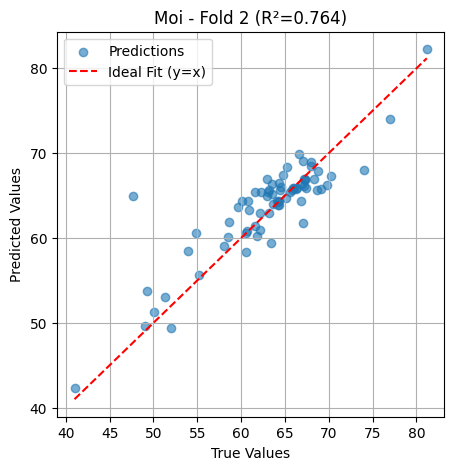

NDF: RMSE=4.623, R2=0.278, Bias=0.513


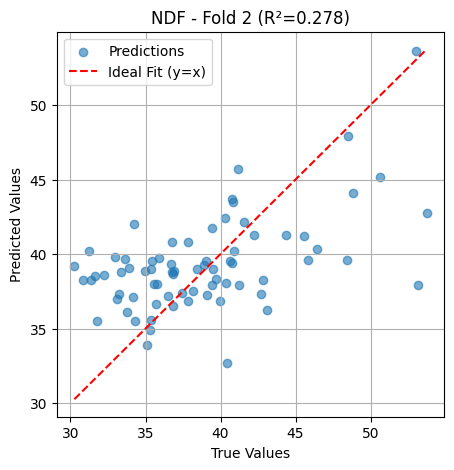

Starch: RMSE=7.052, R2=0.347, Bias=-0.091


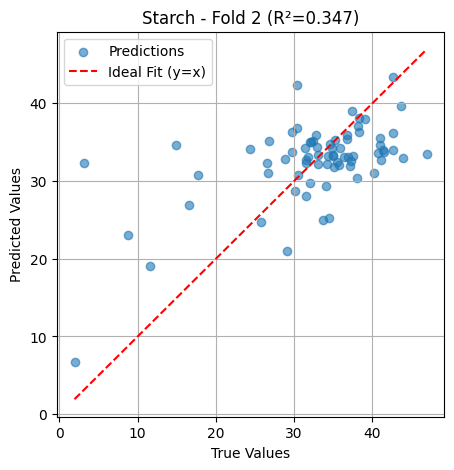


========== Fold 3/5 ==========
Epoch 10/200 | Avg Loss: 0.9370
Epoch 20/200 | Avg Loss: 0.7944
Epoch 30/200 | Avg Loss: 0.7998
Epoch 40/200 | Avg Loss: 0.7825
Epoch 50/200 | Avg Loss: 0.7546
Epoch 60/200 | Avg Loss: 0.7191
Epoch 70/200 | Avg Loss: 0.6123
Epoch 80/200 | Avg Loss: 0.6713
Epoch 90/200 | Avg Loss: 0.5376
Epoch 100/200 | Avg Loss: 0.5336
Epoch 110/200 | Avg Loss: 0.6143
Epoch 120/200 | Avg Loss: 0.5554
Epoch 130/200 | Avg Loss: 0.4900
Epoch 140/200 | Avg Loss: 0.5502
Epoch 150/200 | Avg Loss: 0.4647
Epoch 160/200 | Avg Loss: 0.4810
Epoch 170/200 | Avg Loss: 0.4558
Epoch 180/200 | Avg Loss: 0.4428
Epoch 190/200 | Avg Loss: 0.4038
Epoch 200/200 | Avg Loss: 0.4708

Fold Results:
Moi: RMSE=2.140, R2=0.852, Bias=-0.095


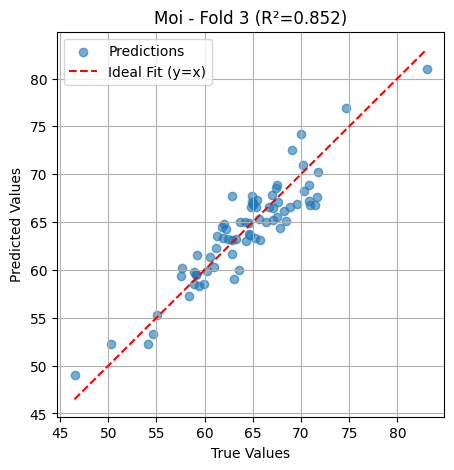

NDF: RMSE=7.135, R2=0.163, Bias=-0.755


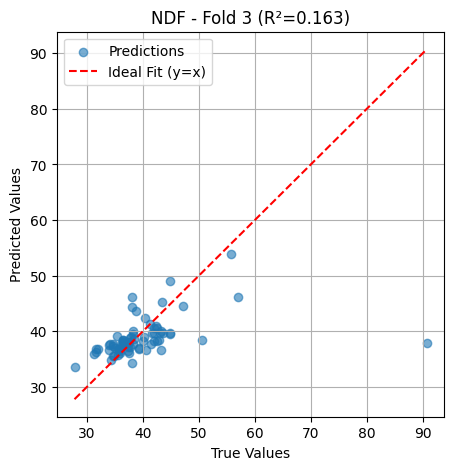

Starch: RMSE=6.680, R2=0.388, Bias=0.374


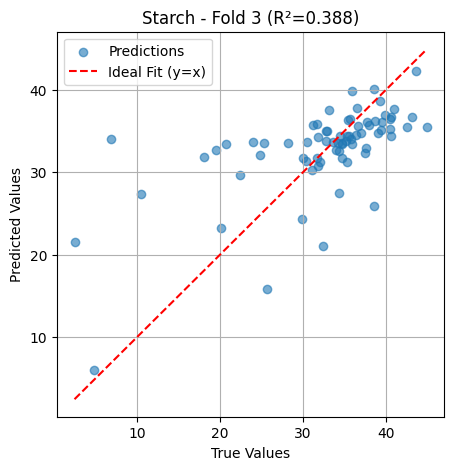


========== Fold 4/5 ==========
Epoch 10/200 | Avg Loss: 0.9803
Epoch 20/200 | Avg Loss: 0.8944
Epoch 30/200 | Avg Loss: 0.8831
Epoch 40/200 | Avg Loss: 0.9180
Epoch 50/200 | Avg Loss: 0.8566
Epoch 60/200 | Avg Loss: 0.8542
Epoch 70/200 | Avg Loss: 0.7873
Epoch 80/200 | Avg Loss: 0.7445
Epoch 90/200 | Avg Loss: 0.6883
Epoch 100/200 | Avg Loss: 0.6048
Epoch 110/200 | Avg Loss: 0.5669
Epoch 120/200 | Avg Loss: 0.5607
Epoch 130/200 | Avg Loss: 0.5711
Epoch 140/200 | Avg Loss: 0.5574
Epoch 150/200 | Avg Loss: 0.5382
Epoch 160/200 | Avg Loss: 0.5339
Epoch 170/200 | Avg Loss: 0.5499
Epoch 180/200 | Avg Loss: 0.4995
Epoch 190/200 | Avg Loss: 0.5682
Epoch 200/200 | Avg Loss: 0.5082

Fold Results:
Moi: RMSE=3.566, R2=0.641, Bias=-1.741


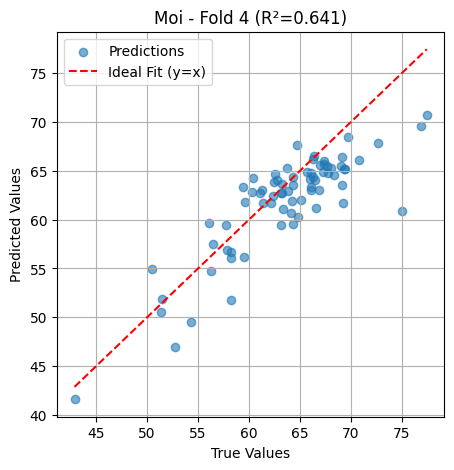

NDF: RMSE=4.533, R2=0.235, Bias=-0.519


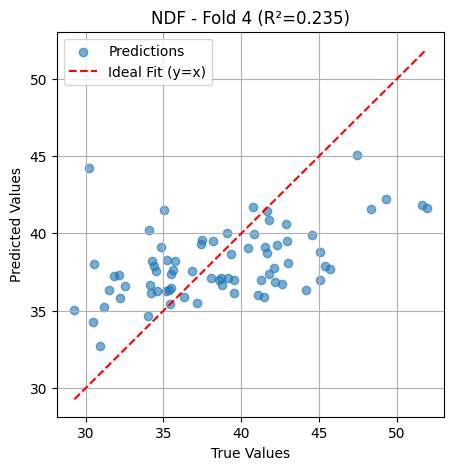

Starch: RMSE=7.423, R2=0.192, Bias=0.759


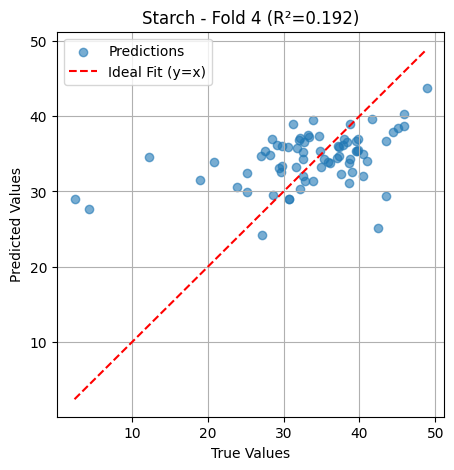


========== Fold 5/5 ==========
Epoch 10/200 | Avg Loss: 1.0153
Epoch 20/200 | Avg Loss: 0.9094
Epoch 30/200 | Avg Loss: 0.9048
Epoch 40/200 | Avg Loss: 0.8995
Epoch 50/200 | Avg Loss: 0.8067
Epoch 60/200 | Avg Loss: 0.7399
Epoch 70/200 | Avg Loss: 0.7022
Epoch 80/200 | Avg Loss: 0.6901
Epoch 90/200 | Avg Loss: 0.5967
Epoch 100/200 | Avg Loss: 0.5961
Epoch 110/200 | Avg Loss: 0.6515
Epoch 120/200 | Avg Loss: 0.5609
Epoch 130/200 | Avg Loss: 0.5495
Epoch 140/200 | Avg Loss: 0.5956
Epoch 150/200 | Avg Loss: 0.5308
Epoch 160/200 | Avg Loss: 0.5209
Epoch 170/200 | Avg Loss: 0.4935
Epoch 180/200 | Avg Loss: 0.4792
Epoch 190/200 | Avg Loss: 0.4737
Epoch 200/200 | Avg Loss: 0.4673

Fold Results:
Moi: RMSE=2.499, R2=0.846, Bias=0.952


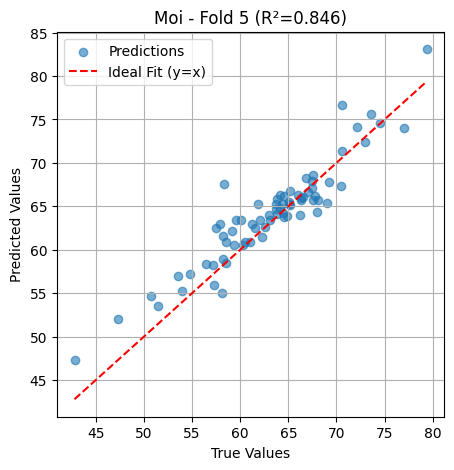

NDF: RMSE=3.991, R2=0.316, Bias=0.908


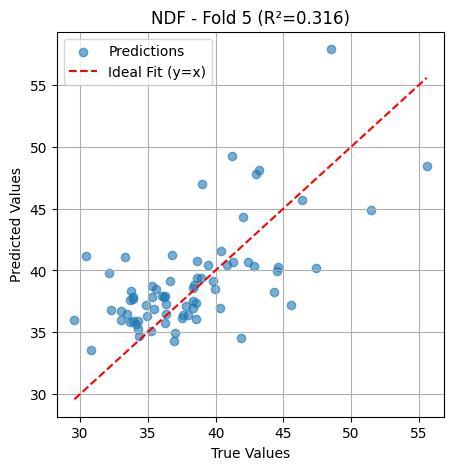

Starch: RMSE=6.376, R2=0.164, Bias=-1.619


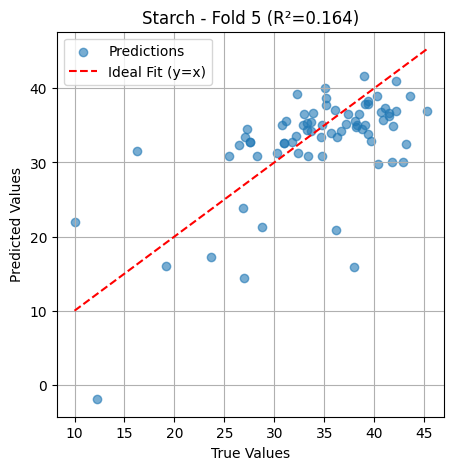

In [69]:
# =============================================
# ====== 9. 5-Fold Cross Validation ======
# =============================================
kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

for fold, (t_idx, v_idx) in enumerate(kf.split(trainval_idx)):
    print(f"\n========== Fold {fold+1}/{n_splits} ==========")

    # Loaders
    train_loader = DataLoader(Subset(dataset, trainval_idx[t_idx]), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(Subset(dataset, trainval_idx[v_idx]), batch_size=batch_size, shuffle=False)

    model = CNN2D().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # ===== Training =====
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        # Print every 10 epochs
        if epoch % 10 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs} | Avg Loss: {avg_loss:.4f}")

    # ===== Validation =====
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb.to(device)).cpu().numpy()
            yb_np = yb.cpu().numpy()
            preds_orig = y_scaler.inverse_transform(preds)
            yb_orig = y_scaler.inverse_transform(yb_np)
            y_true.append(yb_orig)
            y_pred.append(preds_orig)

    y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

    # ===== Metrics =====
    metrics = compute_metrics_orig(y_true, y_pred)
    print("\nFold Results:")
    for i, t in enumerate(TARGETS):
        print(f"{t}: RMSE={metrics[i]['RMSE']:.3f}, R2={metrics[i]['R2']:.3f}, Bias={metrics[i]['Bias']:.3f}")

        # ===== Plot Regression =====
        plt.figure(figsize=(5,5))
        plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
        min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"{t} - Fold {fold+1} (R²={metrics[i]['R2']:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()


In [70]:
# =============================================
# ====== 10. Final Train on all trainval + test ======
# =============================================
final_loader = DataLoader(Subset(dataset, trainval_idx), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(dataset, test_idx), batch_size=batch_size, shuffle=False)

final_model = CNN2D().to(device)
optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
criterion = nn.MSELoss()

print("\n=== Final Training on Full Train+Val Set ===")
for epoch in range(1, epochs + 1):
    final_model.train()
    epoch_loss = 0.0
    for xb, yb in final_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(final_model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_loss / len(final_loader):.4f}")


=== Final Training on Full Train+Val Set ===
Epoch 10/200 | Train Loss: 0.9684
Epoch 20/200 | Train Loss: 0.8634
Epoch 30/200 | Train Loss: 0.8824
Epoch 40/200 | Train Loss: 0.8383
Epoch 50/200 | Train Loss: 0.7953
Epoch 60/200 | Train Loss: 0.8294
Epoch 70/200 | Train Loss: 0.6419
Epoch 80/200 | Train Loss: 0.6772
Epoch 90/200 | Train Loss: 0.6200
Epoch 100/200 | Train Loss: 0.5724
Epoch 110/200 | Train Loss: 0.5753
Epoch 120/200 | Train Loss: 0.5483
Epoch 130/200 | Train Loss: 0.5153
Epoch 140/200 | Train Loss: 0.4989
Epoch 150/200 | Train Loss: 0.5095
Epoch 160/200 | Train Loss: 0.4898
Epoch 170/200 | Train Loss: 0.4963
Epoch 180/200 | Train Loss: 0.4618
Epoch 190/200 | Train Loss: 0.4818
Epoch 200/200 | Train Loss: 0.5051



== Test metrics ==
Moi: RMSE=2.697, R2=0.814, Bias=-0.204


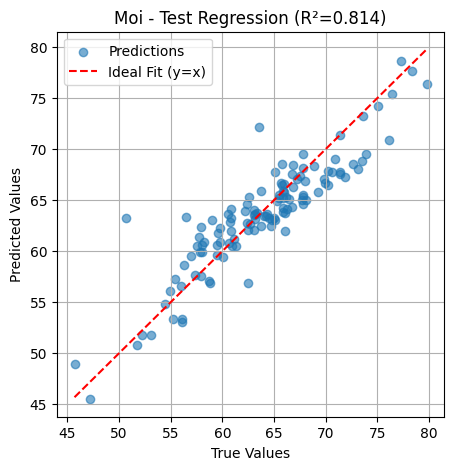

NDF: RMSE=4.417, R2=0.382, Bias=-0.032


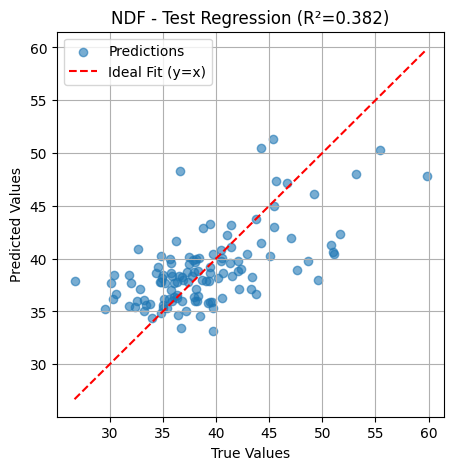

Starch: RMSE=6.046, R2=0.509, Bias=-0.228


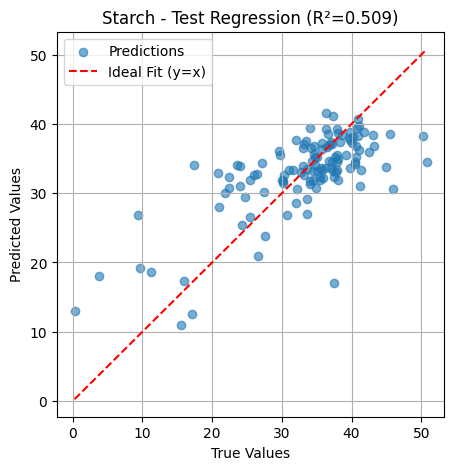

In [72]:
# =============================================
# ====== 11. Final Evaluation ======
# =============================================
final_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = final_model(xb.to(device)).cpu().numpy()
        yb_np = yb.cpu().numpy()
        preds_orig = y_scaler.inverse_transform(preds)
        yb_orig = y_scaler.inverse_transform(yb_np)
        y_true.append(yb_orig)
        y_pred.append(preds_orig)

y_true, y_pred = np.vstack(y_true), np.vstack(y_pred)

test_metrics = compute_metrics_orig(y_true, y_pred)
print("\n== Test metrics ==")
for i, t in enumerate(TARGETS):
    print(f"{t}: RMSE={test_metrics[i]['RMSE']:.3f}, R2={test_metrics[i]['R2']:.3f}, Bias={test_metrics[i]['Bias']:.3f}")
    plt.figure(figsize=(5,5))
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.6, label="Predictions")
    min_val, max_val = y_true[:, i].min(), y_true[:, i].max()
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit (y=x)")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{t} - Test Regression (R²={test_metrics[i]['R2']:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [74]:
# =============================================
# ====== 12. Save Model ======
# =============================================
file_path = f"/content/CR_16_norm.pth"
torch.save(final_model.state_dict(), file_path)
print(f"\n✅ Model saved to: {file_path}")


✅ Model saved to: /content/CR_16_norm.pth


In [58]:
# =============================================
# ====== 13. Targets Info ======
# =============================================
for target in TARGETS:
    print(f"{target}: Min={df[target].min():.3f}, Max={df[target].max():.3f}")

Moi: Min=41.001, Max=83.060
NDF: Min=26.690, Max=90.740
Starch: Min=0.250, Max=50.800
